In [33]:
from glob import glob
from datasets import Dataset
import numpy as np
import pandas as pd
from pprint import pprint
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams["figure.figsize"] = (20, 10)
pd.options.display.max_columns = None
warnings.filterwarnings("ignore")
from pprint import pprint
import json

In [34]:
ds = Dataset.from_json("../crawl/final/final_dataset.jsonl")
ds = ds.filter(lambda x: x["luong"] not in ["Thoả thuận", "Thương lượng", "Cạnh tranh"])
ds.column_names

['vi_tri_viec',
 'ten_cong_ty',
 'dia_diem_lam_viec',
 'ngay_cap_nhat',
 'nganh_nghe',
 'hinh_thuc',
 'luong',
 'cap_bac',
 'het_han_nop',
 'dia_chi_cong_ty',
 'loai_hinh_hoat_dong',
 'quy_mo_cong_ty',
 'num_followers',
 'min_exp',
 'max_exp']

In [35]:
# 2) Extract and reformat salary
def salary_mapper(x):
    try:
        t = None
        if "tr vnd" in x["luong"].lower():
            t = "tr vnd"
        elif "usd" in x["luong"].lower():
            t = "usd"
        min_luong, max_luong = None, None
        if "-" in x["luong"]:
            a, b = x["luong"].split("-")
            temp1 = a.strip().split(" ")[0].replace(",", "").replace(".", "")
            temp2 = b.strip().split(" ")[0].replace(",", "").replace(".", "")
            min_luong = int(temp1)
            max_luong = int(temp2)
        elif "Trên" in x["luong"]:
            min_luong = int(x["luong"].split(" ")[1].replace(",", "").replace(".", ""))
        elif "Lên đến" in x["luong"]:
            max_luong = int(x["luong"].split(" ")[2].replace(",", "").replace(".", ""))
        if t == "usd":
            if min_luong:
                min_luong = min_luong * 23 / 1000
            if max_luong:
                max_luong = max_luong * 23 / 1000
        return {
            "min_luong": min_luong,
            "max_luong": max_luong,
        }
    except Exception as e:
        raise e


ds = ds.map(salary_mapper, remove_columns=["luong"])

Text(0.5, 1.0, 'Phân bố mức lương tại Việt Nam')

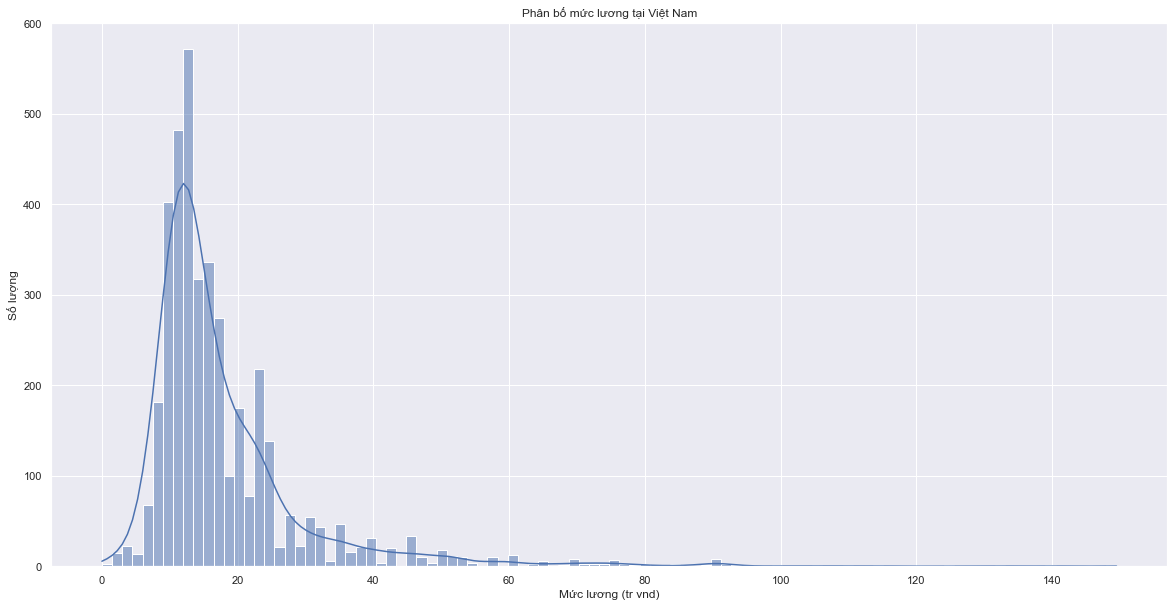

In [36]:
def mapper(x):
    return {
        'average_salary': (x['min_luong'] + x['max_luong']) / 2,
    }

ds = ds.filter(lambda x: x['min_luong'] is not None and x['max_luong'] is not None).map(mapper, remove_columns=['min_luong', 'max_luong']).filter(lambda x: x['average_salary'] < 150)
temp = ds.to_pandas()['average_salary']
sns.histplot(temp, bins=100, kde=True, figure=plt.figure(figsize=(20, 10)))
plt.xlabel('Mức lương (tr vnd)')
plt.ylabel('Số lượng')
plt.title('Phân bố mức lương tại Việt Nam')

In [50]:
ds.to_pandas()["average_salary"].describe()

count    3907.000000
mean       17.880685
std        12.439708
min         0.000000
25%        11.000000
50%        14.000000
75%        20.000000
max       149.500000
Name: average_salary, dtype: float64

In [37]:
ds[0]

{'vi_tri_viec': 'Process Engineering Leader- Trưởng nhóm Kỹ sư Quy trình',
 'ten_cong_ty': 'Công Ty TNHH L.S Pack',
 'dia_diem_lam_viec': 'Hồ Chí Minh',
 'ngay_cap_nhat': '27/11/2023',
 'nganh_nghe': ['Cơ khí / Ô tô / Tự động hóa',
  'Điện / Điện tử / Điện lạnh',
  'Bảo trì / Sửa chữa'],
 'hinh_thuc': ['Nhân viên chính thức'],
 'cap_bac': 'Trưởng nhóm / Giám sát',
 'het_han_nop': '30/12/2023',
 'dia_chi_cong_ty': 'Lô A 2-2 Khu công nghiệp Tây Bắc Củ Chi, ấp Bàu Tre 2 - Xã Tân An Hội - Huyện Củ Chi - TP Hồ Chí Minh, Huyện Củ Chi, HCMC',
 'loai_hinh_hoat_dong': None,
 'quy_mo_cong_ty': '25-99',
 'num_followers': 309.0,
 'min_exp': 1,
 'max_exp': 3,
 'average_salary': 20.0}

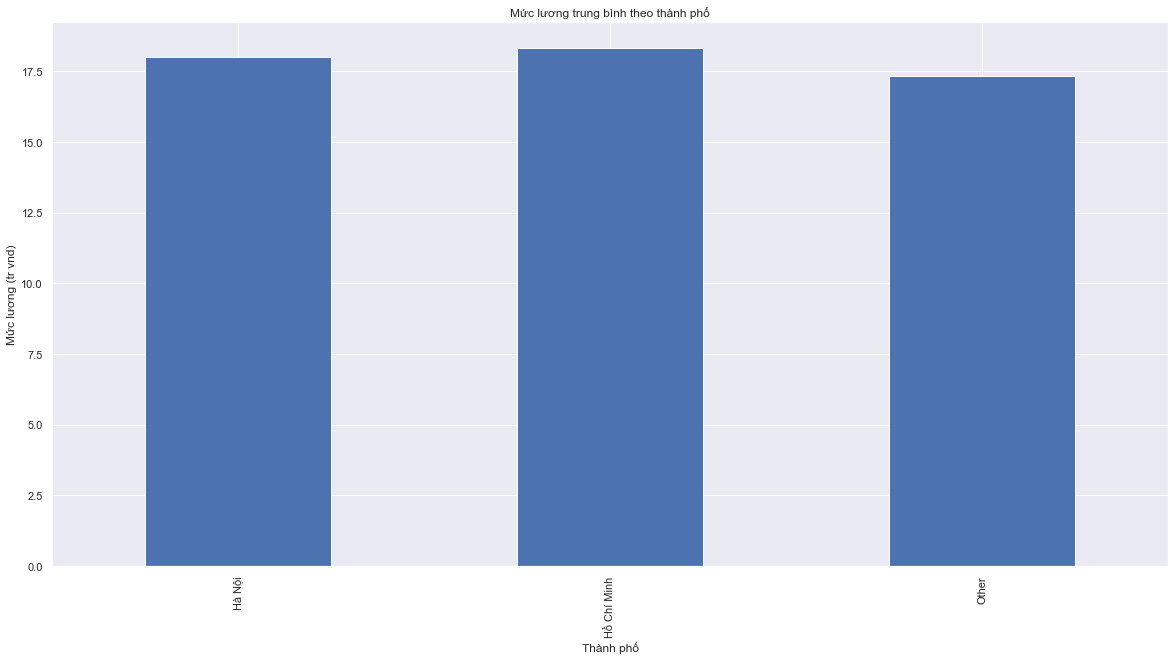

In [38]:
def mapper(x):
    return {
        'main_city': x['dia_diem_lam_viec'] if x['dia_diem_lam_viec'] in ['Hà Nội', 'Hồ Chí Minh'] else 'Other',
    }

ds = ds.map(mapper, remove_columns=['dia_diem_lam_viec'])
ds.to_pandas().groupby('main_city')['average_salary'].mean().plot(kind='bar', figsize=(20, 10))
plt.xlabel('Thành phố')
plt.ylabel('Mức lương (tr vnd)')
plt.title('Mức lương trung bình theo thành phố')
plt.show()

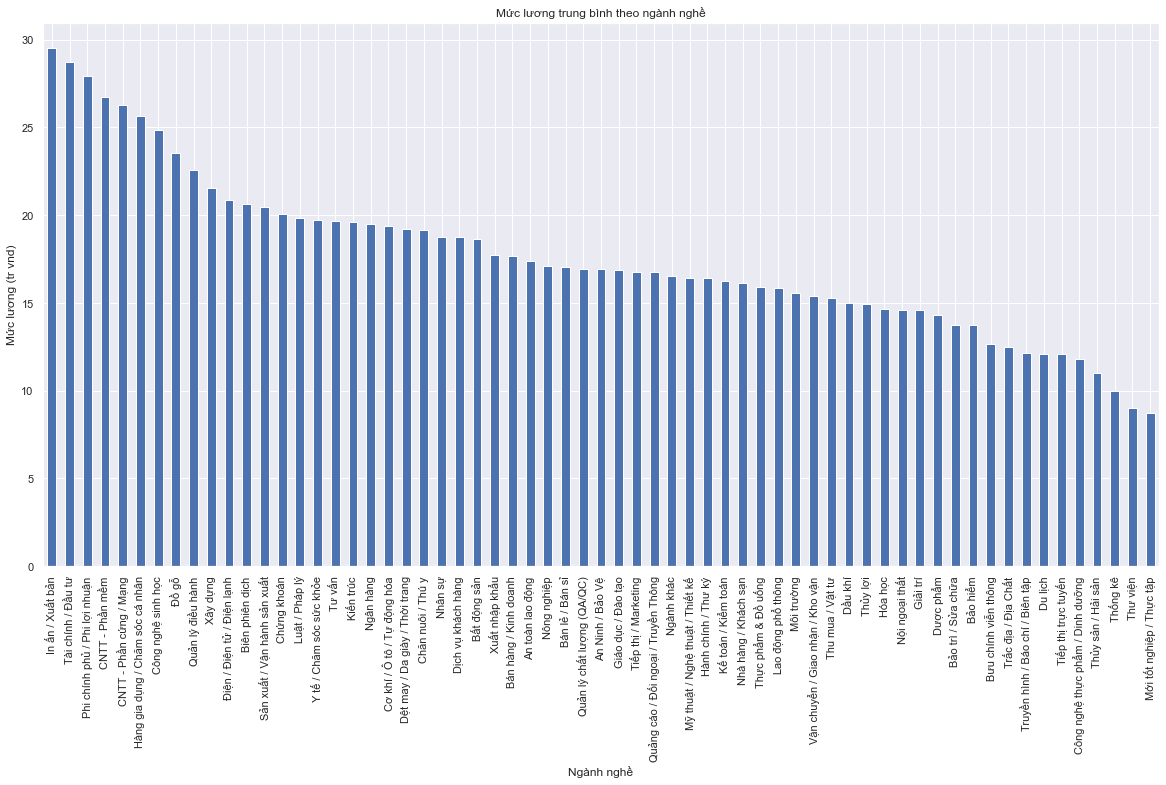

In [46]:
ds.map(lambda x: {'nganh_nghe':x['nganh_nghe'][0]}).to_pandas().groupby('nganh_nghe')['average_salary'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))
plt.xlabel('Ngành nghề')
plt.ylabel('Mức lương (tr vnd)')
plt.title('Mức lương trung bình theo ngành nghề')
plt.show()

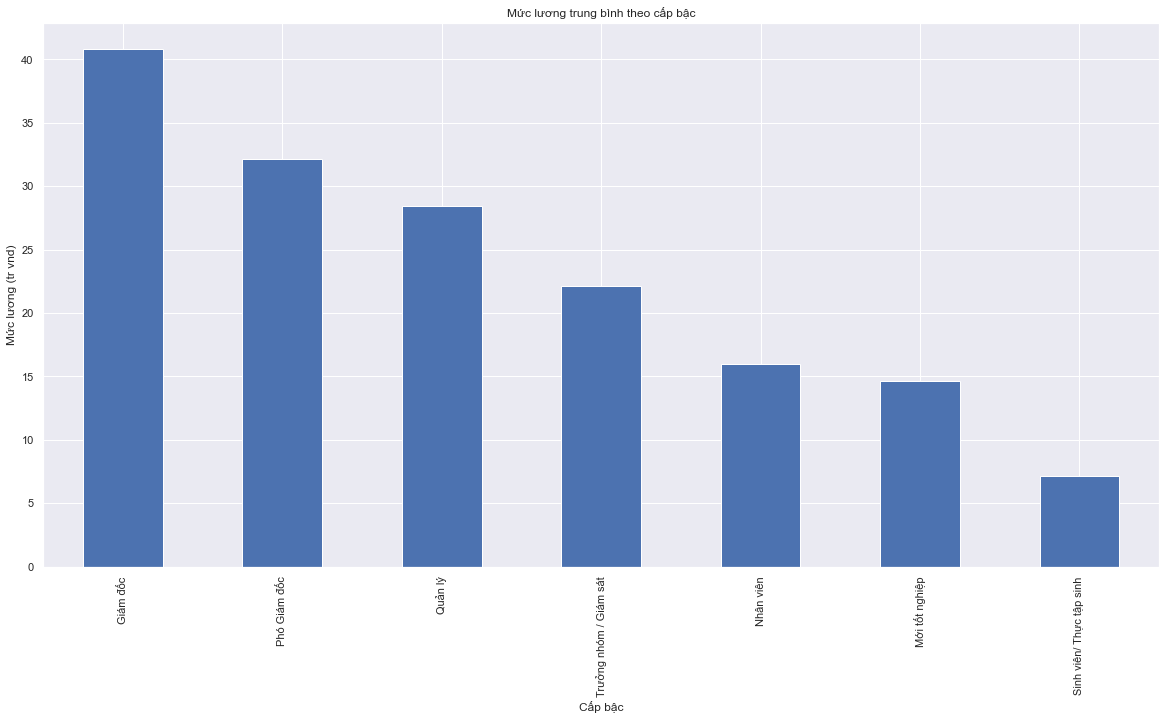

In [48]:
ds.to_pandas().groupby('cap_bac')['average_salary'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))
plt.xlabel('Cấp bậc')
plt.ylabel('Mức lương (tr vnd)')
plt.title('Mức lương trung bình theo cấp bậc')
plt.show()